# Section 1: Cleaning the Data

In [1224]:
# Imports
import pandas as pd
from IPython.display import display
# Import datatypes for parameter type specification
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Decision Tree for comparison
from sklearn.tree import DecisionTreeClassifier

# labels for pairwise plots
from sklearn.preprocessing._label import LabelEncoder

Load the dataset from a file to a dataframe. Drop any attributes with irrelevant data.

In [1225]:
# Load the data file
df = pd.read_csv("./ford.csv")

# drop unecessary columns
df = df.drop(["tax"], axis=1)

# Drop impossible years
mask = df.year > 2022
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

# Cars must have a valid engine size if they are Diesel or Petrol
mask = (df.engineSize == 0.0)
mask = mask & ( (df.fuelType == 'Diesel') | (df.fuelType == 'Petrol') )
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

# drop records with ambiguous fuel type
mask = (df.fuelType == "Other")
index = df.loc[mask].index
df = df.drop(index=index, axis=1)

print(df.shape)



(17913, 8)


In [1226]:
models = df.model.unique()
fuelTypes = df.fuelType.unique()
transmissions = df.transmission.unique()
engineSizes = df.engineSize.unique()

print("Models\n", models,
      "\n\nFuel Types\n", fuelTypes,
      "\n\nTransmissions\n", transmissions,
      "\n\nEngine Sizes\n", engineSizes)

Models
 [' Fiesta' ' Focus' ' Puma' ' Kuga' ' EcoSport' ' C-MAX' ' Mondeo' ' Ka+'
 ' Tourneo Custom' ' S-MAX' ' B-MAX' ' Edge' ' Tourneo Connect'
 ' Grand C-MAX' ' KA' ' Galaxy' ' Mustang' ' Grand Tourneo Connect'
 ' Fusion' ' Ranger' ' Streetka' ' Escort' ' Transit Tourneo'] 

Fuel Types
 ['Petrol' 'Diesel' 'Hybrid' 'Electric'] 

Transmissions
 ['Automatic' 'Manual' 'Semi-Auto'] 

Engine Sizes
 [1.  1.5 1.6 1.2 2.  1.1 2.3 1.4 5.  2.2 2.5 1.8 1.3 3.2 0.  1.7]


### Convert categorical data to numeric format
The target feature is car model. Encode the categorical features as 0 or 1 using `pandas.get_dummies()`. Leave the target feature unchanged.

In [1227]:
print(df.dtypes)

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
mpg             float64
engineSize      float64
dtype: object


In [1228]:
transmissionNumeric = pd.get_dummies(df.transmission)
df = pd.concat([df.drop("transmission", axis=1), transmissionNumeric], axis=1)
fuelTypeNumeric = pd.get_dummies(df.fuelType)
df = pd.concat([df.drop("fuelType", axis=1), fuelTypeNumeric], axis=1)
display(df.head())
df.to_csv("clean1_Ford.csv", index=False)

,model,year,price,mileage,mpg,engineSize,Automatic,Manual,Semi-Auto,Diesel,Electric,Hybrid,Petrol
0,Fiesta,2017,12000,15944,57.7,1.0,1,0,0,0,0,0,1
1,Focus,2018,14000,9083,57.7,1.0,0,1,0,0,0,0,1
2,Focus,2017,13000,12456,57.7,1.0,0,1,0,0,0,0,1
3,Fiesta,2019,17500,10460,40.3,1.5,0,1,0,0,0,0,1
4,Fiesta,2019,16500,1482,48.7,1.0,1,0,0,0,0,0,1


### Drop attributes or records to fine-tune the KNN model

A KNN model on the full dataset yields a high misclassification rate for certain cars such as the "Tourneo Connect" and the "Fusion" models. The cars with higher misclassification rates will isolated to a separate KNN model to study the behavior related to the high misclassification rates.

The primary dataset to be examined is stored to `df` and is exported to the "clean1_Ford.csv" file. 

The car models with high misclassification rates are stored in `df2` and exported to the "clean2_Ford.csv" file.

In [1229]:
df2 = df[df.model == ' Grand Tourneo Connect']
df2 = pd.concat([df2, df[df.model == ' Tourneo Connect']])
df2 = pd.concat([df2, df[df.model == ' Transit Tourneo']])
df2 = pd.concat([df2, df[df.model == ' Tourneo Custom']])
df2 = pd.concat([df2, df[df.model == ' Fusion']])
df2 = pd.concat([df2, df[df.model == ' Ranger']])
df2 = pd.concat([df2, df[df.model == ' Streetka']])
df2 = pd.concat([df2, df[df.model == ' Escort']])
df2 = pd.concat([df2, df[df.model == ' Grand C-MAX']])
df2 = pd.concat([df2, df[df.model == ' Mondeo']])
df2 = pd.concat([df2, df[df.model == ' S-MAX']])
df2.to_csv("clean2_Ford.csv", index=False)

df = df[df.model != ' Grand Tourneo Connect']
df = df[df.model != ' Tourneo Connect']
df = df[df.model != ' Transit Tourneo']
df = df[df.model != ' Tourneo Custom']
df = df[df.model != ' Fusion']
df = df[df.model != ' Ranger']
df = df[df.model != ' Streetka']
df = df[df.model != ' Escort']
df = df[df.model != ' Grand C-MAX']
df = df[df.model != ' Mondeo']
df = df[df.model != ' S-MAX']
df.to_csv("clean1_Ford.csv", index=False)

---

# Section 2 : Scaling the Data

Scale the primary dataset. Additionaly, multiply the "mpg scaled" attribute by a weight of `mpg_weight` to adjust the impact for groupings of this attribute.

In [1230]:
df = pd.read_csv("clean1_Ford.csv")

In [1231]:
mpg_weight = 7.0

# use mpg_col_name to rename the columns after adjusting the "mpg scaled" feature
mpg_col_name = "mpg scaled * " + str(mpg_weight)
print("mpg_col_name: '" + mpg_col_name + "'")

mpg_col_name: 'mpg scaled * 7.0'


In [1232]:
scaler = MinMaxScaler()
X = df.drop("model", axis=1)
scaler.fit(X)
X_scaled = scaler.transform(X)
X.columns = X.columns + " scaled"
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [1233]:
# adjust the 'mpg scaled' feature
mpg_scaled = X_scaled["mpg scaled"].to_frame(name=mpg_col_name)*mpg_weight
X_scaled = pd.concat([X_scaled.drop("mpg scaled", axis=1), mpg_scaled], axis=1)
display(X_scaled.head())

,year scaled,price scaled,mileage scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled,mpg scaled * 7.0
0,0.863636,0.211101,0.089747,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.427072
1,0.909091,0.247798,0.051125,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
2,0.863636,0.229450,0.070113,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.427072
3,0.954545,0.312018,0.058877,0.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.754144
4,0.954545,0.293670,0.008337,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.079006


In [1234]:
X_scaled.to_csv("X_scaled.csv", index=False)
df.model.to_csv("y.csv", index=False)

Scale the secondary dataset

In [1235]:
df2 = pd.read_csv("clean2_Ford.csv")

In [1236]:
scaler2 = MinMaxScaler()
X2 = df2.drop("model", axis=1)
scaler2.fit(X2)
X2_scaled = scaler2.transform(X2)
X2.columns = X2.columns + " scaled"
X2_scaled = pd.DataFrame(X2_scaled, columns=X2.columns)

In [1237]:
mpg_scaled = X2_scaled["mpg scaled"].to_frame(name=mpg_col_name)*mpg_weight
X2_scaled = pd.concat([X2_scaled.drop("mpg scaled", axis=1), mpg_scaled], axis=1)
display(X2_scaled.head())

,year scaled,price scaled,mileage scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled,mpg scaled * 7.0
0,0.958333,0.562972,0.023172,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.615538
1,0.916667,0.446176,0.062815,0.125,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.946215
2,0.875000,0.388143,0.032153,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.615538
3,0.958333,0.562972,0.023172,0.125,0.0,1.0,0.0,1.0,0.0,0.0,0.0,4.615538
4,0.916667,0.446176,0.062815,0.125,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.946215


In [1238]:
X2_scaled.to_csv("X2_scaled.csv", index=False)
df2.model.to_csv("y2.csv", index=False)


---

# Section 3: Designing the KNN Model

Read the scaled data from files. Store the features and targets to variables. These variables will be used for train-test splitting.

In [1239]:
# read scaled data for non-target attributes
X_scaled = pd.read_csv("X_scaled.csv")

# read the target attribute
y = pd.read_csv("y.csv").to_numpy().ravel()

Read scaled data from files for the secondary dataset.

In [1240]:
X2_scaled = pd.read_csv("X2_scaled.csv")

y2 = pd.read_csv("y2.csv").to_numpy().ravel()

### study interactions

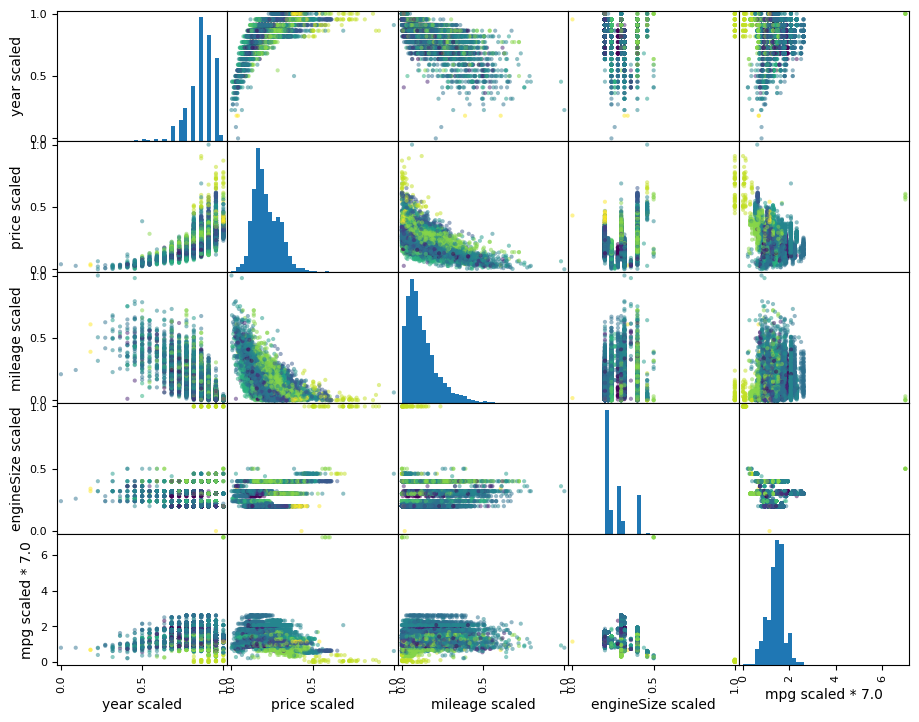

In [1241]:
pd.plotting.scatter_matrix(
    X_scaled[X_scaled.columns[[0,1,2,3,11]]],
    c=LabelEncoder().fit(y).transform(y),
    hist_kwds={'bins':40},
    figsize=(11, 8.5)
)
plt.show()

Divide data into training and test sets

In [1242]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y,
    random_state=0
)

X2_train_scaled, X2_test_scaled, y2_train, y2_test = train_test_split(
    X2_scaled, y2, 
    random_state=0
)

--- 

# Section 4: Decision Tree Comparision

Create a decision tree and a KNN from the primary dataset and compare accuracies of each model

In [1243]:
tree = DecisionTreeClassifier(
    # random_state=0
)
knn = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    pd.read_csv("X_scaled.csv"), 
    pd.read_csv("y.csv"), 
    random_state=0
)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

# hacky way to clear the output
display() 

In [1244]:
print("Primary Dataset, accuracies on the test set")
print("tree accuracy: " + str(tree.score(X_test_scaled, y_test)))
print("knn accuracy: " + str(knn.score(X_test_scaled, y_test)))

Primary Dataset, accuracies on the test set
tree accuracy: 0.9539126260201632
knn accuracy: 0.9443110897743638


Create a decision tree and a KNN from the secondary dataset and compare accuracies of each model

In [1245]:
tree = DecisionTreeClassifier(
    # random_state=0
)
knn = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X2_train_scaled, X2_test_scaled, y2_train, y2_test = train_test_split(
    pd.read_csv("X2_scaled.csv"),
    pd.read_csv("y2.csv"),
    random_state=0
)
y2_train = np.ravel(y2_train)
y2_test = np.ravel(y2_test)

tree.fit(X2_train_scaled, y2_train)
knn.fit(X2_train_scaled, y2_train)
display() # hacky way to clear the output

In [1246]:
print("Secondary Dataset, accuracies on the test set")
print("tree accuracy: " + str(tree.score(X2_test_scaled, y2_test)))
print("knn accuracy: " + str(knn.score(X2_test_scaled, y2_test)))

Secondary Dataset, accuracies on the test set
tree accuracy: 0.8881789137380192
knn accuracy: 0.8881789137380192


---